# Guide: Hallucination Scoring

This cookbook gets you started detecting hallucinations, and runs over a sample set from the public benchmark [RAGTruth](https://arxiv.org/abs/2401.00396) benchmark - a large-scale corpus of naturally generated hallucinations, featuring detailed word-level annotations specifically designed for retrieval-augmented generation (RAG) scenarios.
<br>

We check for hallucination in AI responses i.e. 'Is the information provided in the response directly supported by the context given in the related passages?' and compare how Selene's scores align with the human labels.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atla-ai/atla-sdk-python/blob/main/cookbooks/Atla_Selene_Hallucination.ipynb)

## Setup

### Install dependencies

In [8]:
# Install Atla.
!pip install atla --quiet

# Install other dependencies for this notebook.
!pip install asyncio --quiet
!pip install datasets --quiet
!pip install matplotlib --quiet
!pip install nest_asyncio --quiet
!pip install pandas --quiet
!pip install scikit-learn --quiet
!pip install seaborn --quiet

### Set up Atla API key


You can get your Atla API key for free [here](https://www.atla-ai.com/sign-up).

In [9]:
from atla import Atla, AsyncAtla

ATLA_API_KEY = "<your_api_key>" # replace with your own API key

client = Atla(api_key=ATLA_API_KEY)
async_client = AsyncAtla(api_key=ATLA_API_KEY)

## Run an initial example

### Inspect the data

Here's a quick example for evaluating an AI legal assistant from our [RAG quickstart](https://docs.atla-ai.com/build/use-cases/rag).

In [10]:
# This is the input that was provided to the LLM
example_input = "Is it legal to monitor employee emails under European privacy laws?"

# This is the RAG context that was provided to the LLM
example_context = """- European privacy laws, including GDPR, allow for the monitoring of employee emails under strict conditions.
- The employer must demonstrate that the monitoring is necessary for a legitimate purpose, such as protecting company assets or compliance with legal obligations.
- Employees must be informed about the monitoring in advance, and the privacy impact should be assessed to minimize intrusion."""

# This is the response the LLM gave
example_answer = """Monitoring employee emails is permissible under European privacy laws like GDPR, provided there's a legitimate purpose."""

# This answer is not a hallucination as it contains information that is supported by the provided context.

### Run the Atla API

Let's try using the Atla API to get a score and feedback from Selene.

We can start off using one of our [default metrics](https://docs.atla-ai.com/build/metrics/default). These metrics cover common evaluation scenarios and are optimized for immediate use.


<br>

In this RAG case, we'll want to use `atla_default_faithfulness`. This metric evaluates how faithful a model's response is to the provided context and returns a ["Likert"](https://en.wikipedia.org/wiki/Likert_scale) score from 1-5.

> Certain default metrics require specific fields to be provided. For `atla_default_faithfulness`, we need to provide:
>
> * `model_input`
> * `model_output`
> * `model_context`

In [11]:
import textwrap

evaluation = client.evaluation.create(
    model_id="atla-selene",
    model_input=example_input,
    model_context=example_context,
    model_output=example_answer,
    metric_name="atla_default_faithfulness" # Choose the faithfulness metric
).result.evaluation

print("\nScore:", evaluation.score) # Print Selene's score
print("\nCritique:")
print("\n".join(textwrap.wrap(evaluation.critique, width=80))) # Print Selene's critique



Score: 4

Critique:
The response accurately reflects the context by stating that monitoring employee
emails is permissible under European privacy laws like GDPR, provided there's a
legitimate purpose. This aligns with the information given that employers must
demonstrate a legitimate purpose for monitoring. However, it could be improved
by mentioning the necessity of informing employees in advance and assessing the
privacy impact, as these are also crucial conditions mentioned in the context.
Overall, the response is concise and directly supported by the context, with
only minor aspects not covered.


### Customize evaluation criteria

`atla_default_faithfulness`'s 1-5 scale is fine-grained rather than a simple classification. If we want to score our responses as a binary pass/fail, we could set a threshold on the response score (e.g., anything 3 or below is a fail).

<br>

Alternatively, we can configure Selene to use a different evaluation criteria. Let's say we annotate our test samples `0` or `1` like in the dataset we will explore later, where:

- `0` is scored if the response contains information not supported by the passages ("hallucination")
- `1` is scored if the response is factually accurate and supported by the passages

We can define this and replace the `metric_name` argument with our custom `evaluation_criteria`. This way, we can directly get our classification.

> Note that **only one** of `metric_name` and `evaluation_criteria` can be used at a time.

In [12]:
hallucination_criteria = """Evaluate whether the information provided in the response is factually accurate and directly supported by the context given in the related passages.
  0: The response contains any information that is not supported by the passages, includes fabricated details, or misinterprets the information from the passages.
  1: The response is factually accurate and directly supported by the information provided in the passages, without any fabricated or hallucinated details."""

evaluation = client.evaluation.create(
    model_id="atla-selene",
    model_input=example_input,
    model_context=example_context,
    model_output=example_answer,
    evaluation_criteria=hallucination_criteria # Provide the evaluation criteria
).result.evaluation

print("\nScore:", evaluation.score) # Print Selene's score
print("\nCritique:")
print("\n".join(textwrap.wrap(evaluation.critique, width=80))) # Print Selene's critique



Score: 1

Critique:
The response accurately reflects the information provided in the context
regarding the conditions under which employee emails can be monitored under
European privacy laws. It correctly states that monitoring is permissible for a
legitimate purpose, aligning with the details given in the context. However, it
could be improved by mentioning the necessity of informing employees and
assessing privacy impact, as these are crucial aspects of the law. Despite this,
the response remains factually accurate and directly supported by the context.


**We will use this hallucination criteria prompt in the next section** 🔽

## Run batch evals

If we want to [test multiple examples](https://docs.atla-ai.com/build/best-practices), we can use Atla's async client to run multiple evaluations in parallel.

### Load our hallucination test data

We load test data from the publicly accessible [RAGTruth](https://arxiv.org/abs/2401.00396) benchmark using a [Hugging Face dataset](https://huggingface.co/datasets/flowaicom/RAGTruth_test).

This dataset measures **RAG hallucination**:

> *Based on the provided news article, does the summary contain **only** information that is supported by or directly inferable from the news article?*

Examples are scored `0` if they contain information **not supported** by the passages ("hallucination") and `1` if they are factually accurate and supported by the passages.

In [13]:
from datasets import load_dataset
from itertools import islice

# Load only the first 25 samples
RAGTruth_dataset = load_dataset("flowaicom/RAGTruth_test", split="qa", streaming=True) # set token = <YOUR HUGGINGFACE API KEY> if running into permission issues
RAGTruth_dataset = list(islice(RAGTruth_dataset, 25))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.23k [00:00<?, ?B/s]

### Process the data

Now, we need to do a bit of preprocessing with [`pandas`](https://pandas.pydata.org/).

In [14]:
import pandas as pd
import json

# Convert to df
hallucination_df = pd.DataFrame(RAGTruth_dataset)

# Parse the source_info column and create new columns
if isinstance(hallucination_df['source_info'].iloc[0], str):
    # If source_info is a string, parse it
    hallucination_df['source_info'] = hallucination_df['source_info'].apply(json.loads)
elif isinstance(hallucination_df['source_info'].iloc[0], dict):
    # If source_info is already a dictionary, no need to parse
    pass

# Extract question and passages
hallucination_df['question'] = hallucination_df['source_info'].apply(lambda x: x['question'])
hallucination_df['passages'] = hallucination_df['source_info'].apply(lambda x: x['passages'])

# Select only the necessary columns
hallucination_df = hallucination_df[['id', 'question', 'passages', 'response', 'score']]

hallucination_df.head()

,id,question,passages,response,score
0,11904,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...",Automotive technicians can be paid in various ...,1
1,11905,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...",Automotive technicians can be paid through a c...,1
2,11906,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...",Unable to answer based on given passages.,1
3,11907,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...","Based on the provided passages, here is the an...",1
4,11908,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...","Based on the provided passages, automotive tec...",0


### Define our async evaluation function

This function is flexible enough to be used with a generic dataframe.

> Remember, only one of `evaluation_criteria` and `metric_name` can be used at a time.

In [15]:
import asyncio
from typing import Optional

async def evaluate_responses_atla(
    df,
    input_col: str,
    output_col: str,
    evaluation_criteria: Optional[str] = None,
    metric_name: Optional[str] = None,
    context_col: Optional[str] = None,
    ground_truth_col: Optional[str] = None
) -> None:
    """
    Asynchronously evaluate responses using Selene and add results to dataframe.
    """
    if evaluation_criteria and metric_name:
        raise ValueError("Only one of evaluation_criteria or metric_name can be provided")

    async def evaluate_single_row(row):
        try:
            eval_params = {
                "model_id": "atla-selene",
                "model_input": row[input_col],
                "model_output": row[output_col]
            }

            if evaluation_criteria:
                eval_params["evaluation_criteria"] = evaluation_criteria
            if metric_name:
                eval_params["metric_name"] = metric_name
            if context_col and context_col in row:
                eval_params["model_context"] = row[context_col]
            if ground_truth_col and ground_truth_col in row:
                eval_params["expected_model_output"] = row[ground_truth_col]

            result = await async_client.evaluation.create(**eval_params)
            return result.result.evaluation.score, result.result.evaluation.critique
        except Exception as e:
            print(f"Error evaluating row {row.name}: {e}")
            return None, None

    df_copy = df.copy()
    tasks = [evaluate_single_row(row) for _, row in df_copy.iterrows()]
    results = await asyncio.gather(*tasks)

    df_copy['selene_score'] = [int(score) if score is not None else None for score, _ in results]
    df_copy['selene_critique'] = [critique for _, critique in results]

    return df_copy

### Run custom evaluation criteria

We apply our function to the RAGTruth dataframe, using the custom `evaluation_criteria` from earlier.

In [16]:
# Helps us run async code in a Colab notebook.
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Run the function.
hallucination_evaluated = asyncio.run(evaluate_responses_atla(
    hallucination_df,
    input_col='question',
    context_col='passages',
    output_col='response',
    evaluation_criteria=hallucination_criteria)
)

In [17]:
# Inspect our results.
hallucination_evaluated.head()

,id,question,passages,response,score,selene_score,selene_critique
0,11904,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...",Automotive technicians can be paid in various ...,1,1,The response accurately reflects the informati...
1,11905,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...",Automotive technicians can be paid through a c...,1,1,The response accurately reflects the payment m...
2,11906,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...",Unable to answer based on given passages.,1,1,The response is factually accurate in stating ...
3,11907,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...","Based on the provided passages, here is the an...",1,1,The response accurately reflects the informati...
4,11908,how do automotive technicians get paid,"passage 1:In short, whether mechanics and tech...","Based on the provided passages, automotive tec...",0,0,The response accurately identifies that automo...


### Inspect results

Let's see how well Selene aligned with the human grades!

We look at a few analyses:

1. **Accuracy**: This simply tells us how many of the human scores Selene's scores match with.

- You'll want this to be as high as possible - a good rule of thumb is to aim for moderate (50-75%) or high (≥75%) accuracy scores.



2. **Score Distribution**: This gives us an overview of human vs. Selene score distributions, in case we need to prompt Selene to be harsher or more lenient.
- You'll want these score distributions to match closely.


3. **Confusion Matrix**: This gives us detail into the specific failure modes of Selene. We can examine false negatives (in our example, where Selene didn't detect hallucinations) and false positives (in our example, where Selene falsely flagged hallucinations).  

- You may to want to minimize a certain type of error, depending on your application requirements.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

#### Accuracy

In [19]:
correct = (hallucination_evaluated['selene_score'] == hallucination_evaluated['score']).sum()
incorrect = (hallucination_evaluated['selene_score'] != hallucination_evaluated['score']).sum()
print(f"Correct: {correct}, Incorrect: {incorrect}")
print(f"Accuracy: {correct / (correct + incorrect)}")

Correct: 24, Incorrect: 1
Accuracy: 0.96


#### Score distribution

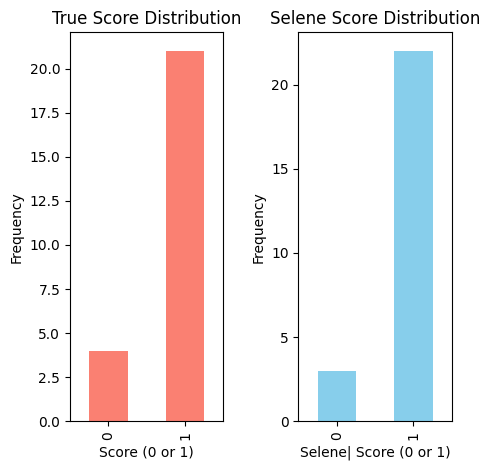

In [20]:
plt.subplot(132)
hallucination_evaluated['score'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Human Score Distribution')
plt.xlabel('Score (0 or 1)')
plt.ylabel('Frequency')
plt.xticks([0, 1], [0, 1])

plt.subplot(133)
hallucination_evaluated['selene_score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Selene Score Distribution')
plt.xlabel('Selene| Score (0 or 1)')
plt.ylabel('Frequency')
plt.xticks([0, 1], [0, 1])

plt.tight_layout()
plt.show()

Here we have a pretty good match! Humans mostly labelled for no hallucination in our test data, and so did Selene.

#### Confusion matrix

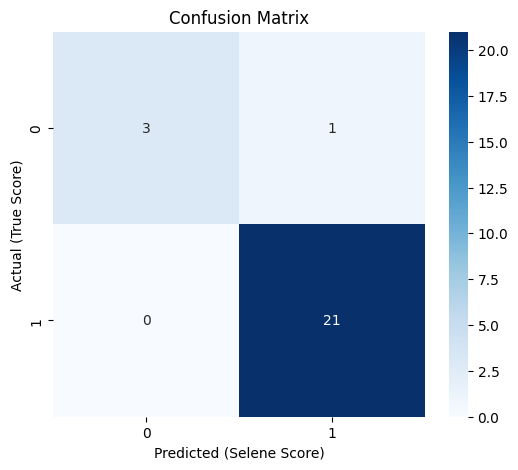

In [21]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(hallucination_evaluated['score'], hallucination_evaluated['selene_score'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted (Selene Score)')
plt.ylabel('Actual (Human Score)')
plt.show()

Here, we care more about false negatives (the top-right cell in our confusion matrix) as we want to minimize missing human-labeled hallucinations. There is only one sample in the top right - which gives us confidence!

As best practice, you can inspect this sample to confirm the accuracy of the human label. If you agree with it, consider adding it as a few-shot example to help seed your custom evaluation metric.

### Conclusions

As we can see from the experiment above, Selene is exceptionally capable out of the box on standard benchmarks.

With the Atla [Alignment Platform](https://docs.atla-ai.com/build/usage/alignment-platform), you can fine-tune eval prompts for your specific use cases on your own data to achieve even better results!

[Sign up here](https://www.atla-ai.com/sign-up) to get access right away.
Join our [Discord](https://discord.gg/qFCMgkGwUK) or [email us](mailto:support@atla-ai.com) if we can support you in any way on your eval journey.